## News Mood
##### Basic
- This program was originally run around 6/28/2018. As of 4:54 PM EST, the following mean compound polarity data was returned and plotted:
- @BBC   ,     0.133081
- @CBS    ,    0.355032
- @CNN    ,   -0.033302
- @FoxNews  ,  0.034071
- @nytimes ,  -0.002570


##### Analysis
- Regardless of the time pulled, it appears that most tweets between numerous accounts return with a calculated compound polarity of 0.
- The 6/28 results clearly showed that CBS had more tweets calculated than any of the other news sites. I visited the CBS Twitter around this time and a large portion of the last 100 tweets at this time are TV promos. The other 4 outlets are known for their political coverage, so this makes sense.
- I wouldn't be surprised if these corporations run these types of analyses on their own Twitter accounts, as they seem to follow their relative trend to around the same numbers. With the exception of CBS, my bar plot looks similar to the results given in the example dated January 2017.

In [1]:
#dependencies
import tweepy
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from twitconfig import consumer_key, consumer_secret, access_token, access_token_secret
import os

#vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#twitter authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [2]:
# 1. Function will take in the string name of a twitter user.
# 2. It will spit out a DataFrame for a single user with sentiment analysis and dates when called.
# 3. Calling a function will look like sentimentblender("@CNN") to return a DataFrame of CNN's analyzed tweets

def sentimentblender(user):
    target_user = user
    
    #for counting how many tweets ago one tweet was
    counter = 1
    
    # we'll be putting a dict into here and this will be converted into a DataFrame in the end
    sentiments = []
    
    #set variable to help count the oldest tweet
    oldest_tweet = None
    
    for x in range(5):
        public_tweets = api.user_timeline(target_user, max_id=oldest_tweet)
        
        for tweet in public_tweets:
            
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            tweets_ago = counter
        
            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1

            # Add sentiments for each tweet into a list
            sentiments.append({"User": target_user,
                                "Date": tweet["created_at"], 
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neu,
                               "Neutral": neg,
                               "Tweets Ago": counter})

            # Add to counter 
            counter += 1
            
    return pd.DataFrame.from_dict(sentiments)
    

In [3]:
#run the function for all the twitter users we want to look at and demonstrate one to see that it works
bbc_df = sentimentblender("@BBC")
cbs_df = sentimentblender("@CBS")
cnn_df = sentimentblender("@CNN")
nyt_df = sentimentblender("@nytimes")
fox_df = sentimentblender("@FoxNews")

bbc_df.head()

,Compound,Date,Negative,Neutral,Positive,Tweets Ago,User
0,-0.2960,Thu Jun 28 19:05:04 +0000 2018,0.901,0.099,0.000,1,@BBC
1,0.0000,Thu Jun 28 18:02:05 +0000 2018,1.000,0.000,0.000,2,@BBC
2,0.4696,Thu Jun 28 16:13:35 +0000 2018,0.861,0.000,0.139,3,@BBC
3,-0.1280,Thu Jun 28 16:00:25 +0000 2018,0.753,0.133,0.115,4,@BBC
4,0.0000,Thu Jun 28 15:52:28 +0000 2018,1.000,0.000,0.000,5,@BBC


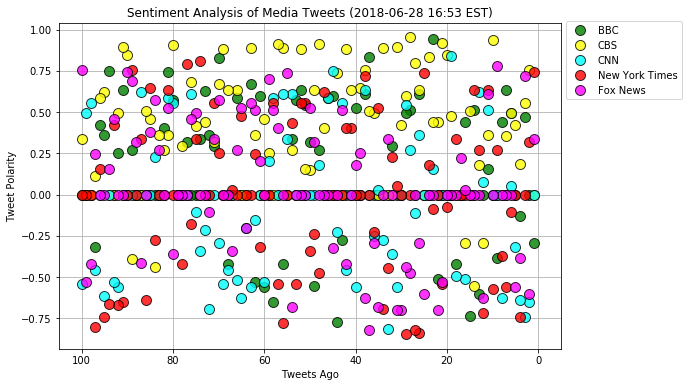

In [4]:
#scatter plotting
plt.figure(figsize=(9,6))
plt.plot(bbc_df['Tweets Ago'], bbc_df['Compound'], marker="o", ms=10, color="green", mec="black", linewidth=0, alpha=0.8, label="BBC")
plt.plot(cbs_df['Tweets Ago'], cbs_df['Compound'], marker="o", ms=10, color="yellow", mec="black", linewidth=0, alpha=0.8, label="CBS")
plt.plot(cnn_df['Tweets Ago'], cnn_df['Compound'], marker="o", ms=10, color="cyan", mec="black", linewidth=0, alpha=0.8, label="CNN")
plt.plot(nyt_df['Tweets Ago'], nyt_df['Compound'], marker="o", ms=10, color="red", mec="black", linewidth=0, alpha=0.8, label="New York Times")
plt.plot(fox_df['Tweets Ago'], fox_df['Compound'], marker="o", ms=10, color="fuchsia", mec="black", linewidth=0, alpha=0.8, label="Fox News")

now = datetime.now()
plottime = now.strftime("%Y-%m-%d %H:%M")
savetime = now.strftime("%Y-%m-%d--%H-%M")
plt.xlim(105,-5)
plt.title(f"Sentiment Analysis of Media Tweets ({plottime} EST)")
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.legend(loc="best", bbox_to_anchor=(1.25, 1.02))
plt.grid(True)

#start saving these logs
plt.savefig(f'scatterplot_{savetime}.png', bbox_inches='tight')
plt.show()

In [5]:
#concatenate the dfs to put them all in one big DataFrame
dfs = [bbc_df, cbs_df, cnn_df, nyt_df, fox_df]
merged_dfs = pd.concat(dfs)

#groupby user
usergroup = merged_dfs.groupby('User')

#use the two variables we declared above to set our x and y values for our bar plot
usernames = merged_dfs['User'].unique().tolist()
meancompound = usergroup['Compound'].mean()

meancompound

User
@BBC        0.133081
@CBS        0.355032
@CNN       -0.033302
@FoxNews    0.034071
@nytimes   -0.002570
Name: Compound, dtype: float64

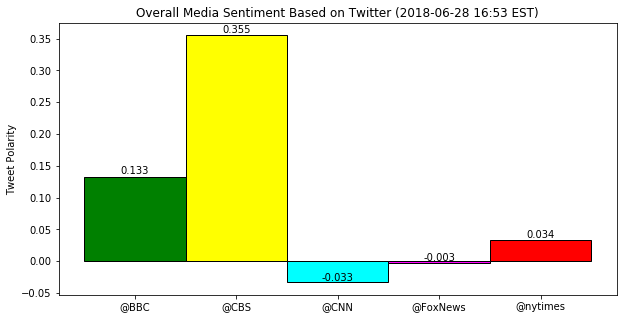

In [6]:
#bar plotting
plt.figure(figsize=(10,5))
colors = ['green', 'yellow', 'cyan', 'red', 'fuchsia']
sentbars = plt.bar(usernames, meancompound, align='center', color=colors, edgecolor='black', width=1.0)
plt.ylabel("Tweet Polarity")
plt.title(f"Overall Media Sentiment Based on Twitter ({plottime} EST)")

# numbers on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, 1.004*height, '%.3f' %float(height), ha='center', va='bottom')
        
autolabel(sentbars)

plt.savefig(f'barplot_{savetime}.png')
plt.show()

In [7]:
#save the big DataFrame into a csv
merged_dfs.to_csv(f'sentiments_{savetime}.csv', index=False, header=True)
print("All done!")

All done!
